# Assignment 2 
## Solar Flare Prediction using SVM

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import sklearn

Preprocess the data to prepare it for the model
- Normalizing the features
- Removing missing values, if any
- Assigning appropriate labels to positive and negative observations

In [2]:
from sklearn.preprocessing import StandardScaler

def preprocess_data(X):
    """
    Preprocess the data by removing missing values and normalizing features.
    
    Parameters:
    X (numpy.ndarray): Input feature array.
    
    Returns:
    X_scaled (numpy.ndarray): Preprocessed feature array.
    """

    # Remove rows with missing values
    X_clean = X[~np.isnan(X).any(axis=1)]

    # Normalize 
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)

    return X_scaled


Function that assigns positive and negative labels

In [3]:
def create_labels(n_pos, n_neg):
    """
    Create labels for positive and negative observations.

    Parameters:
    n_pos (int): Number of positive observations.
    n_neg (int): Number of negative observations.

    Returns:
    y (numpy.ndarray): Array of labels (1 for positive, 0 for negative).
    """

    y = np.concatenate(
        (np.ones(n_pos), np.zeros(n_neg))
    )
    return y

Now, lets build a function that will create an input data array by concatenating all features into a single 2D array. this function will allow for the input for any combination of feature sets to create the input data array. 

For example (FS-I, FS-II) will create the input data array with these 2 feature sets concatenated.

First I will create an enum to represent the feature set. and a dataset key-val pair to get the correct data from the correct dataset

In [4]:
from enum import Enum, auto

class FeatureSet(Enum):
    FS_I = auto()   # Main features (first 18 columns of X_time)
    FS_II = auto()  # Time-change features (columns 19-90 of X_time)
    FS_III = auto() # Historical features (X_hist)
    FS_IV = auto()  # Max-Min features (X_maxmin)

DATA_DIRS = {
    "2020": "data-2020-24",
    "2010": "data-2010-15"
}

Create the function to concatenate inputted feature set:

In [5]:
def build_input_data(
    selected_sets: list[FeatureSet],
    dataset_key: str = "2020" 
):
    """
    Build input data by loading and combining selected feature sets.

    Parameters:
    selected_sets (list[FeatureSet]): List of feature sets to include.
    dataset_key (str): Key to select dataset directory.

    Returns:
    X (numpy.ndarray): Combined feature array.
    y (numpy.ndarray): Array of labels.
    """
    base = DATA_DIRS[dataset_key]

    if FeatureSet.FS_I in selected_sets or FeatureSet.FS_II in selected_sets:
        # --- load time (FS-I + FS-II) ---
        X_pos_time = np.load(os.path.join(base, "pos_features_main_timechange.npy"))
        X_neg_time = np.load(os.path.join(base, "neg_features_main_timechange.npy"))
        FS_I_pos,  FS_I_neg  = X_pos_time[:, :18],  X_neg_time[:, :18]
        FS_II_pos, FS_II_neg = X_pos_time[:, 18:],  X_neg_time[:, 18:]

    if FeatureSet.FS_III in selected_sets:
        # --- load hist (FS-III) ---
        X_pos_hist = np.load(os.path.join(base, "pos_features_historical.npy"))
        X_neg_hist = np.load(os.path.join(base, "neg_features_historical.npy"))

    if FeatureSet.FS_IV in selected_sets:
        # --- load maxmin (FS-IV) ---
        X_pos_maxmin = np.load(os.path.join(base, "pos_features_maxmin.npy"))
        X_neg_maxmin = np.load(os.path.join(base, "neg_features_maxmin.npy"))

    y_pos_meta = np.load(os.path.join(base, "pos_class.npy"), allow_pickle=True)
    y_neg_meta = np.load(os.path.join(base, "neg_class.npy"), allow_pickle=True)
    n_pos, n_neg = len(y_pos_meta), len(y_neg_meta)


    # Collect selected feature sets
    parts_pos, parts_neg = [], []
    for fs in selected_sets:
        if fs == FeatureSet.FS_I:
            parts_pos.append(FS_I_pos)
            parts_neg.append(FS_I_neg)
        elif fs == FeatureSet.FS_II:
            parts_pos.append(FS_II_pos)
            parts_neg.append(FS_II_neg)
        elif fs == FeatureSet.FS_III:
            parts_pos.append(X_pos_hist)
            parts_neg.append(X_neg_hist)
        elif fs == FeatureSet.FS_IV:
            parts_pos.append(X_pos_maxmin)
            parts_neg.append(X_neg_maxmin)

    # Combine positive + negative samples
    X_pos = np.hstack(parts_pos)
    X_neg = np.hstack(parts_neg)
    X = np.vstack([X_pos, X_neg])

    # Preprocess data
    X = preprocess_data(X)

    # Binary labels
    y = create_labels(n_pos, n_neg)

    # print(f"[{dataset_key}] Using sets: {[fs.name for fs in selected_sets]}")
    # print(f"  Combined shape: {X.shape} (features={X.shape[1]})")
    # print(f"  Labels: {len(y)} total ({n_pos} pos, {n_neg} neg)")

    return X, y


Next I will create the function that performs classification using scikit-learns SVC. the inputs will be the input data array X, the label array y, and hyperparameters C, gamma and the kernel

In [6]:
from sklearn.svm import SVC

def train_svm_model(
        X_train: np.ndarray,
        y_train: np.ndarray,
        C: float = 1.0,
        gamma: str | float = 'scale',
        kernel: str = "rbf",
):
    
    model = SVC(C=C, gamma=gamma, kernel=kernel)
    model.fit(X_train,y_train)
    return model

Next create a function that will evalauate the trained model on any given X_test and y_test set.

In [105]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

def evaluate_model(
        model: SVC,
        X_test: np.ndarray,
        y_test: np.ndarray,
):
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    tpr =  tp / (tp + fn) 
    fpr = fp / (fp + tn)
    tss = tpr - fpr

    metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "tss": tss,
        "confusion_matrix": cm
    }

    return metrics

Next I will build the function that iterates over all combination of feature sets and finds the combination with the best accuracy.
for this we will rank the models by Tss Score.

In [112]:
from itertools import combinations
from sklearn.model_selection import StratifiedKFold


def rank_models_by_tss():

    all_sets = [FeatureSet.FS_I, FeatureSet.FS_II, FeatureSet.FS_III, FeatureSet.FS_IV]
    combos = []
    for r in range(1, len(all_sets)+1):
        combos.extend(combinations(all_sets, r))

    results = []
    for combo in combos:
        combo_name = "+".join([fs.name for fs in combo])

        X, y = build_input_data(list(combo), "2010")

        # Use random_state for reproducibility
        sfk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        metrics_list = []
        overall_cm = np.array([[0,0],[0,0]])

        for train_idx, test_idx in sfk.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            model = train_svm_model(X_train, y_train, C=1, gamma="scale", kernel='linear')
            metrics = evaluate_model(model, X_test, y_test)
            metrics_list.append(metrics)
            overall_cm += metrics["confusion_matrix"]

        # Aggregate mean ± std
        keys = ["accuracy", "precision", "recall", "f1_score", "tss"]
        mean_metrics = {k: float(np.mean([m[k] for m in metrics_list])) for k in keys}
        std_metrics  = {k: float(np.std( [m[k] for m in metrics_list])) for k in keys}

        SVM_results = {
            "combo": combo_name,
            "overall_cm": overall_cm,
            **{f"{k}_mean": mean_metrics[k] for k in keys},
            **{f"{k}_std":  std_metrics[k]  for k in keys},
        }
        results.append(SVM_results)

    return results

Create a function to visualize Bar chart showing the performance of each model feature set combination across each fold

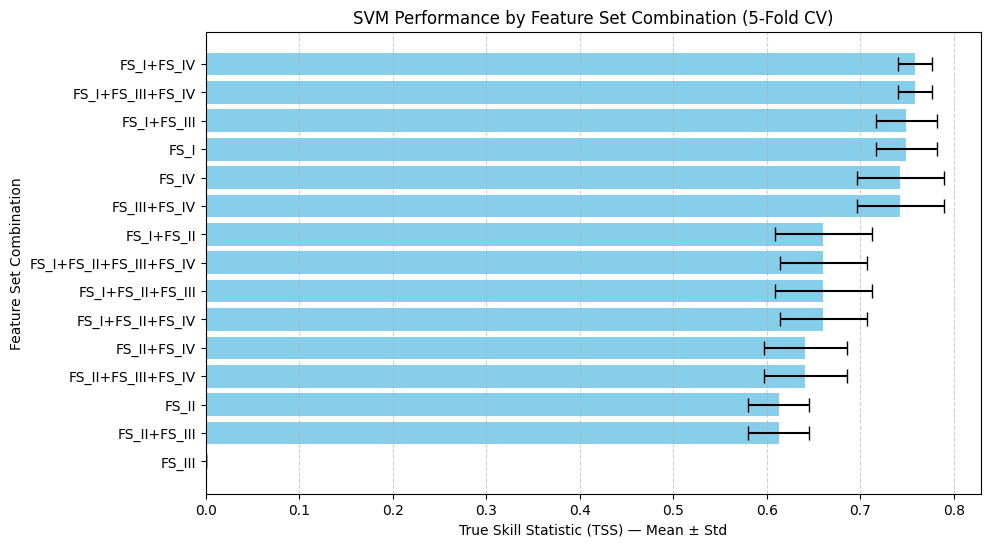

In [104]:
def plot_tss_bar_chart(results):

    df = pd.DataFrame(results)

    df = df.sort_values(by="tss_mean", ascending=False)

    plt.figure(figsize=(10,6))
    plt.barh(
        df["combo"],
        df["tss_mean"],
        xerr=df["tss_std"],
        color='skyblue',
        ecolor='black',
        capsize=5
    )
    plt.xlabel("True Skill Statistic (TSS) — Mean ± Std")
    plt.ylabel("Feature Set Combination")
    plt.title("SVM Performance by Feature Set Combination (5-Fold CV)")
    plt.gca().invert_yaxis() 
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.show()


results = rank_models_by_tss()
plot_tss_bar_chart(results)


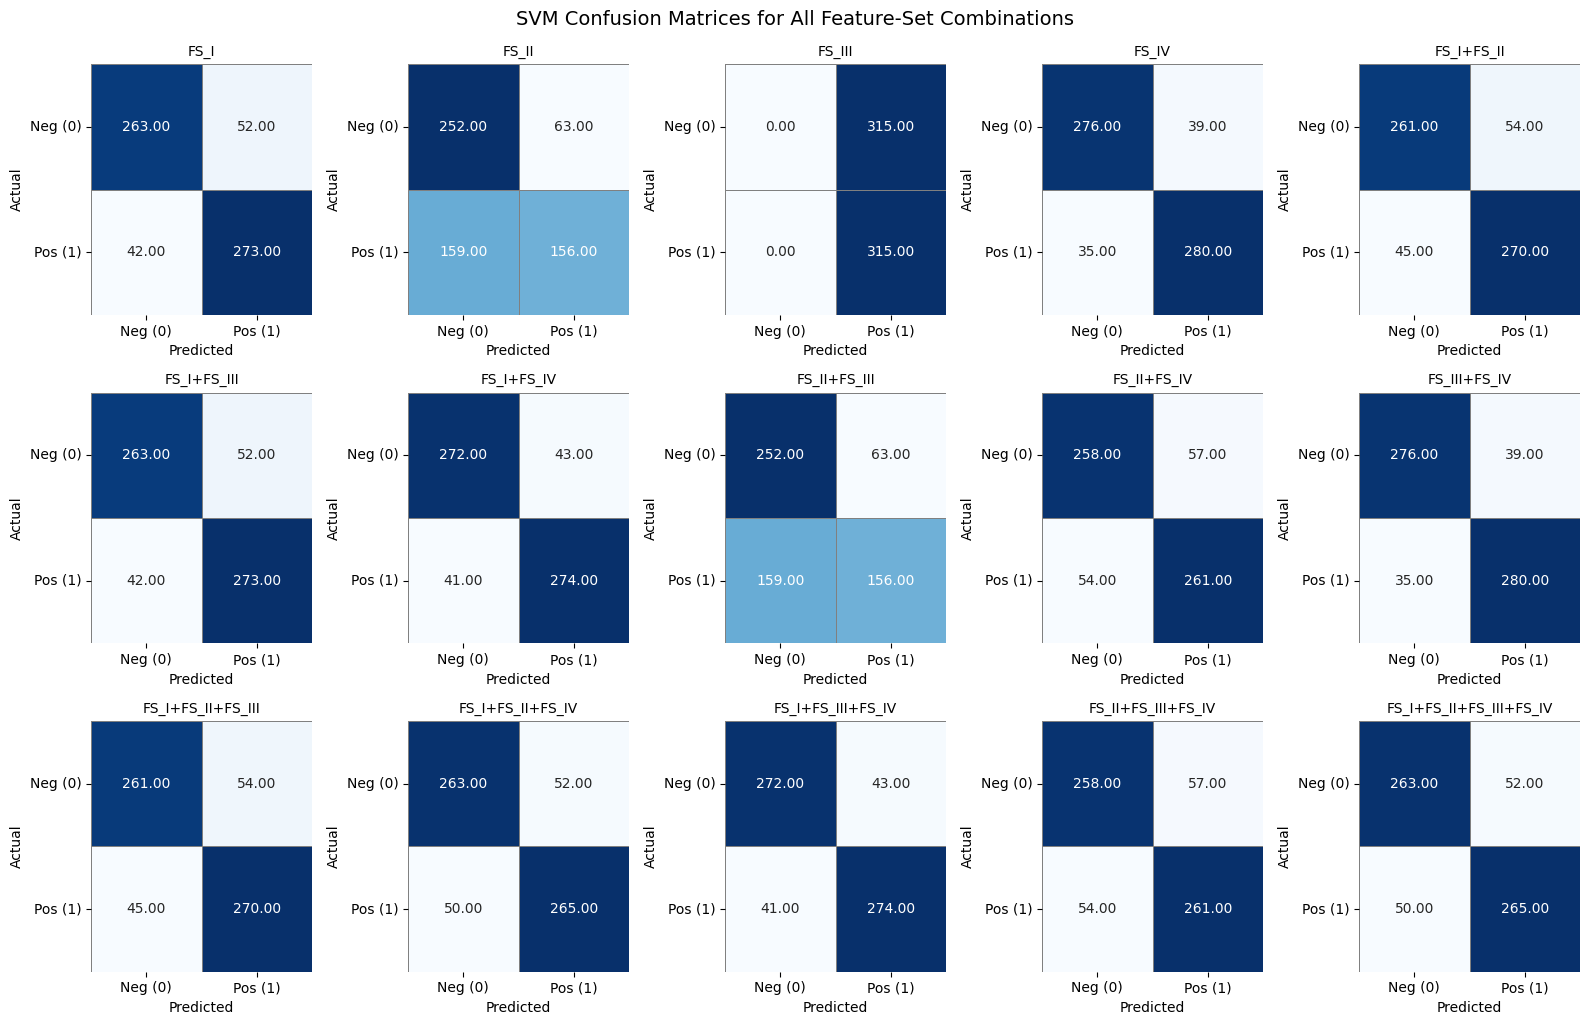

In [114]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def make_confusion_matrix_summary(results):
    ncols=5
    figsize=(16, 10)
    df = pd.DataFrame(results)
    n = len(df)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    for i, (_, row) in enumerate(df.iterrows()):
        cm = np.array(row["overall_cm"]).astype(float)
        combo = row["combo"]
        sns.heatmap(
            cm,
            annot=True,
            fmt=".2f",
            cmap="Blues",
            cbar=False,
            ax=axes[i],
            linewidths=0.5,
            linecolor="gray"
        )
        axes[i].set_title(combo, fontsize=10)
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")
        axes[i].set_xticklabels(["Neg (0)", "Pos (1)"])
        axes[i].set_yticklabels(["Neg (0)", "Pos (1)"], rotation=0)

    # Hide empty subplots if total < nrows*ncols
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.suptitle(
        "SVM Confusion Matrices for All Feature-Set Combinations",
        fontsize=14, y=1.02
    )
    plt.show()

results = rank_models_by_tss()
make_confusion_matrix_summary(results)

Standalone code to test:
- build_input_data: include feature sets and year

=== Mean ± Std across 5 folds ===
Accuracy  : 0.8683 ± 0.0254
Precision : 0.8662 ± 0.0327
Recall    : 0.8730 ± 0.0449
F1_score  : 0.8686 ± 0.0268
Tss       : 0.7365 ± 0.0508


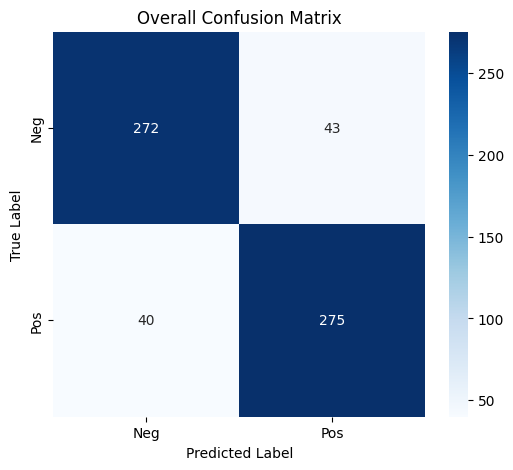

In [100]:
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

X, y = build_input_data([FeatureSet.FS_I, FeatureSet.FS_II], "2010")
sfk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

metrics_list = []
for train_idx, test_idx in sfk.split(X,y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = train_svm_model(X_train, y_train, C=10, gamma=0.001, kernel='rbf')
    metrics = evaluate_model(model, X_test, y_test)
    metrics_list.append(metrics)

keys = ["accuracy", "precision", "recall", "f1_score", "tss"]
mean_metrics = {k: np.mean([m[k] for m in metrics_list]) for k in keys}
std_metrics  = {k: np.std([m[k] for m in metrics_list])  for k in keys}
print("=== Mean ± Std across 5 folds ===")
for k in keys:
    print(f"{k.capitalize():<10}: {mean_metrics[k]:.4f} ± {std_metrics[k]:.4f}")

# Add confusion matrix np arrays together to get overall confusion matrix
overall_cm = np.zeros((2,2), dtype=int)
for m in metrics_list:
    overall_cm += m["confusion_matrix"]

# Plot overall confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg','Pos'], yticklabels=['Neg','Pos'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix')
plt.show()



Grid search to find the best hyperparameters:

In [99]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, confusion_matrix


def tss_scorer(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) else 0
    fpr = fp / (fp + tn) if (fp + tn) else 0
    return tpr - fpr

tss_metric = make_scorer(tss_scorer, greater_is_better=True)


def find_best_svm_hyperparameters(X, y):
    """
    Perform grid search over SVM hyperparameters using 5-fold CV.
    Returns best estimator and results.
    """
    param_grid = {
        'C': [0.1, 1, 5, 10, 50, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'kernel': ['rbf', 'linear', 'poly'],
        'class_weight': [None, 'balanced']
    }

    svc = SVC()
    grid = GridSearchCV(
        svc,
        param_grid,
        scoring=tss_metric,      # or 'f1', or custom TSS scorer
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X, y)

    print("\nBest Parameters:")
    print(grid.best_params_)
    print(f"Best 5-fold CV Accuracy: {grid.best_score_:.4f}")

    return grid.best_estimator_, grid.cv_results_

X, y = build_input_data([FeatureSet.FS_I, FeatureSet.FS_II], "2010")
best_model, cv_results = find_best_svm_hyperparameters(X, y)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best Parameters:
{'C': 10, 'class_weight': None, 'gamma': 0.001, 'kernel': 'rbf'}
Best 5-fold CV Accuracy: 0.7270
